# Using LSTM Recurrent NN to predict number of deaths due to COVID in Italy according to deaths, recovered and cases


In [25]:
import pandas as pd

dataset_deaths: pd.DataFrame = pd.read_csv(
    "../data/processed/global_death_per_country.csv", index_col=0, parse_dates=True
)["Italy"].fillna(0).to_frame("Deaths")
dataset_cases: pd.DataFrame = pd.read_csv(
    "../data/processed/global_confirmed_per_country.csv",
    index_col=0,
    parse_dates=True,
)["Italy"].fillna(0).to_frame("Cases")
dataset_recovred: pd.DataFrame = pd.read_csv(
    "../data/processed/global_recovered_per_country.csv", index_col=0, parse_dates=True
)["Italy"].fillna(0).to_frame("Recovered")
dataset = pd.concat([dataset_deaths, dataset_cases, dataset_recovred], axis=1)


In [26]:
# Removing outliers, filtering by value inferior to 3*std and taking only the values up to august 2k21
import numpy as np
import datetime as dt

dataset = dataset[np.abs(dataset - dataset.mean()) <= (3 * dataset.std()) ]
dataset = dataset.loc[:'2021-8-1']

<AxesSubplot:>

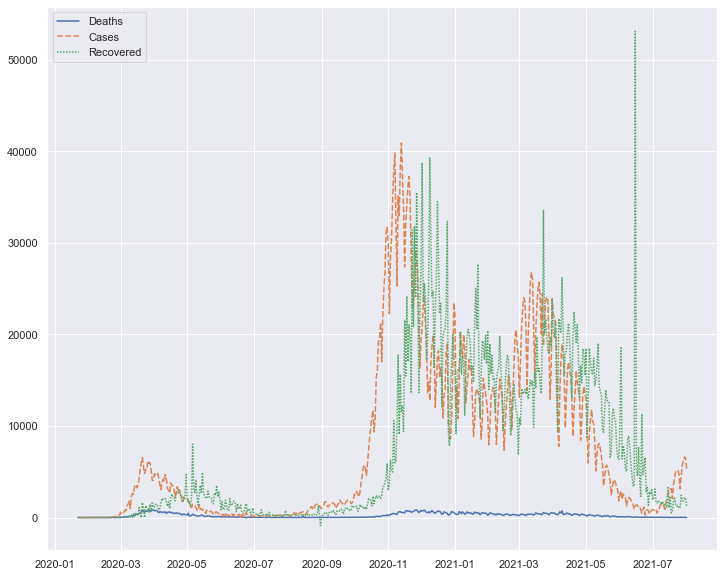

In [27]:
import seaborn as sns

sns.set(rc={"figure.figsize": (12, 10)})
sns.set_theme()

sns.lineplot(data=dataset)


# Scaling and pre-processing time series into supervised time series

In [28]:
from sklearn.preprocessing import MinMaxScaler


def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [("var%d(t-%d)" % (j + 1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [("var%d(t)" % (j + 1)) for j in range(n_vars)]
        else:
            names += [("var%d(t+%d)" % (j + 1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg


scaler = MinMaxScaler(feature_range=(0, 1))
scaled_dataset = scaler.fit_transform(dataset)

dataset_reframed = series_to_supervised(scaled_dataset, 1, 1)
dataset_reframed.drop(dataset_reframed.columns[[4, 5]], axis=1, inplace=True)


# Train-test split

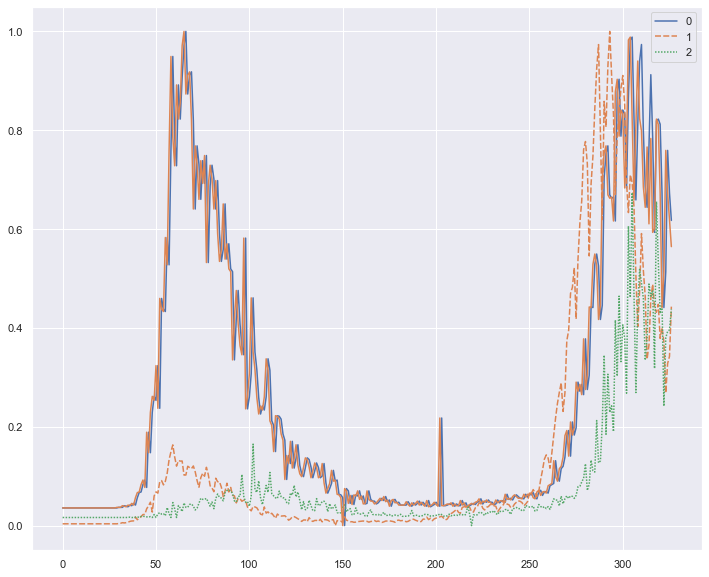

In [29]:
slice_pourcentage = 0.6
index_slice = int(len(dataset_reframed) * slice_pourcentage)
train = dataset_reframed.values[:index_slice, :]
test = dataset_reframed.values[index_slice:, :]

# turn into supervised problem
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
sns.lineplot(data=train_X)
sns.lineplot(data=train_y)

# reshape input to be 3D [samples, timesteps, features] for LSTM compliance
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))


# Training

In [31]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

EPOCHS = 100
BATCH_SIZE = 72

model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(test_X, test_y), shuffle=False)


Epoch 1/100
5/5 [==============================] - 2s 100ms/step - loss: 0.2271 - val_loss: 0.2778
Epoch 2/100
5/5 [==============================] - 0s 7ms/step - loss: 0.2068 - val_loss: 0.2541
Epoch 3/100
5/5 [==============================] - 0s 9ms/step - loss: 0.1871 - val_loss: 0.2322
Epoch 4/100
5/5 [==============================] - 0s 9ms/step - loss: 0.1778 - val_loss: 0.2161
Epoch 5/100
5/5 [==============================] - 0s 9ms/step - loss: 0.1725 - val_loss: 0.2035
Epoch 6/100
5/5 [==============================] - 0s 9ms/step - loss: 0.1682 - val_loss: 0.1929
Epoch 7/100
5/5 [==============================] - 0s 9ms/step - loss: 0.1642 - val_loss: 0.1832
Epoch 8/100
5/5 [==============================] - 0s 8ms/step - loss: 0.1604 - val_loss: 0.1743
Epoch 9/100
5/5 [==============================] - 0s 9ms/step - loss: 0.1566 - val_loss: 0.1658
Epoch 10/100
5/5 [==============================] - 0s 9ms/step - loss: 0.1528 - val_loss: 0.1577
Epoch 11/100
5/5 [=========

<AxesSubplot:>

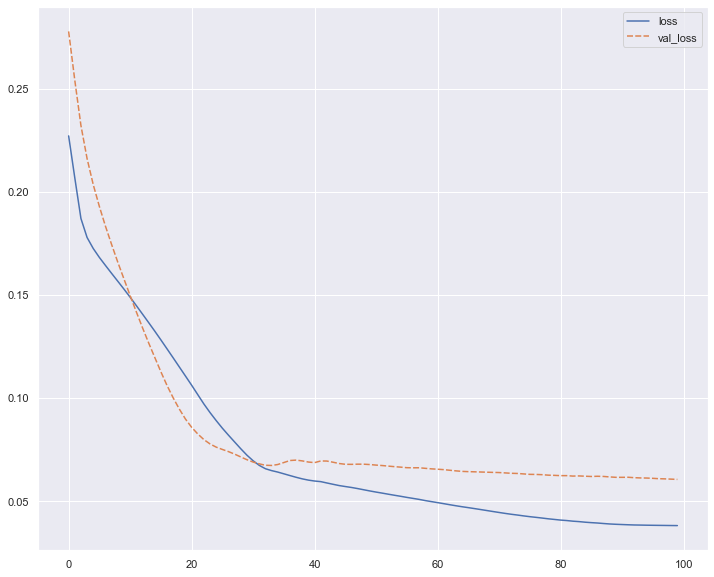

In [32]:
sns.lineplot(data=history.history)

# Evaluating model

In [33]:
import math
from sklearn.metrics import mean_squared_error

# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = math.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)


Test RMSE: 77.940


[Text(0.5, 1.0, 'Italty COVID prediction, RSME=0.08979206723458438')]

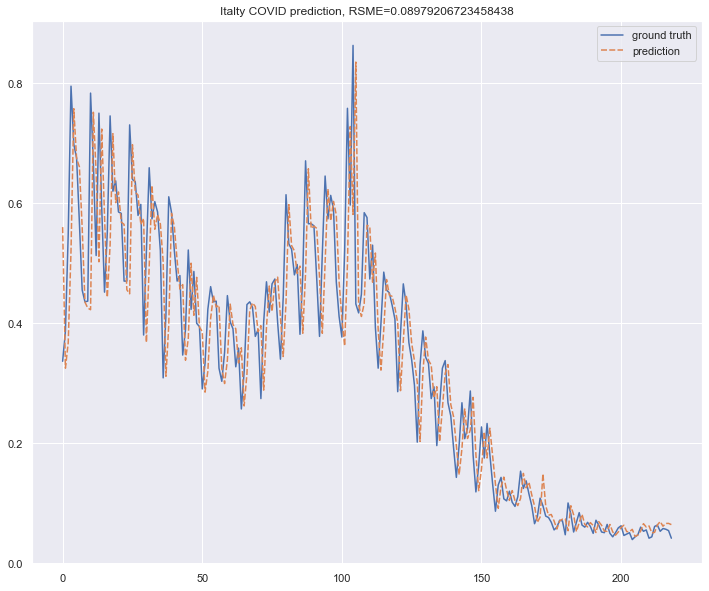

In [43]:
sns.lineplot(data={"ground truth": test_y.flatten(), "prediction": yhat.flatten()}).set(
    title=f"Italty COVID prediction, RSME={rmse}")

<AxesSubplot:>

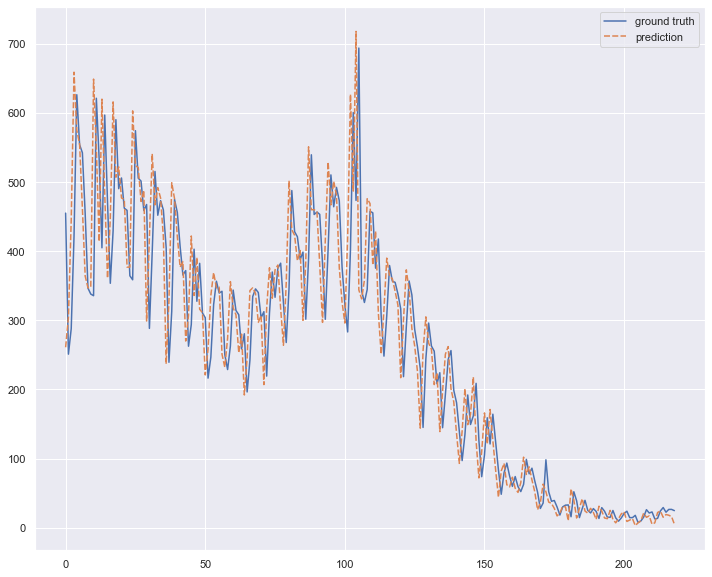

In [46]:
sns.lineplot(data={"ground truth": inv_yhat, "prediction": inv_y})